## Notebook for 1D BDT scan and calculating FOMs in Bd2psi2SKS on data


In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('/home/chasenberg/repos/')
import os
import sys
import ROOT
from ROOT import TFile, TH1D, TH2D, TCanvas, gStyle, TLine, TTree
from ROOT import (RooArgSet, RooRealVar, RooDataSet, RooPlot, RooFit, RooStats, RooArgList)
import root_pandas as rp
import root_numpy as ry 

import math
import itertools
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

from root_pandas import read_root
import pandas as pd

sys.path.append('/home/vmueller/repos')
from dopy.doroot.root_utils import read_roodataset_from_tree, plot_pulls
from dopy.doplot.plotting import Plotter, Plot                

In [2]:

from ROOT import RooRealVar, RooExponential, RooExtendPdf, RooAddPdf, RooArgList, RooGaussian
from ROOT import RooFormulaVar
from ROOT import gSystem
gSystem.Load('libRooFit.so')
gSystem.Load('/home/chasenberg/repos/dopy/dolib/CustomShapes/libKll')
from ROOT import RooIpatia2

### Read ROOT file

In [3]:
dataset_file_name = '/fhgfs/users/chasenberg/mc/2015_2016_merged/jpsimumuks/Bd2JpsiKS_selected.root'

In [4]:
branches = [
            'B0_TAGOMEGA_OS',
            'B0_TAGDECISION_OS',
            'B0_TAU',
            'B0_TAUERR',
            'B0_TRUETAU',
            'B0_FitPVConst_MinIPCHI2anyPV_flat',
            'idxRunNumber',
            'idxEventNumber',
            'idxPV'
            ]

In [5]:
l0_cut =  '((abs(1115.683-varLambda0MassHypo_ppluspiminus)>17)|piplus_ProbNNp<0.4)&((abs(1115.683-varLambda0MassHypo_pminuspiplus)>17)|(piminus_ProbNNp<0.4))'

In [6]:
tree_mc = 'Bd2JpsiKS'
signal_dataframe_wrongPV  = rp.read_root(dataset_file_name,key=tree_mc,columns=branches,where=l0_cut, flatten=False)
signal_dataframe_wrongPV  = signal_dataframe_wrongPV.replace([np.inf, -np.inf], np.nan)
signal_dataframe_wrongPV  = signal_dataframe_wrongPV.dropna()

In [7]:
signal_dataframe_wrongPV['Delta_TAU'] = signal_dataframe_wrongPV['B0_TAU'] -signal_dataframe_wrongPV['B0_TRUETAU']

In [8]:
signal_dataframe_wrongPV.to_root('/fhgfs/users/chasenberg/mc/2015_2016_merged/jpsimumuks/interim_random.root',key='Bd2JpsiKS')

In [9]:
'''test_1 = pd.DataFrame()
test_2 = pd.DataFrame()
test_3 = pd.DataFrame()
for row in signal_dataframe_wrongPV.itertuples():
    print("yes")
pv_num = signal_dataframe_wrongPV['runNumber'].unique()
pv_num = np.array(pv_num)
print(len(pv_num))
for nums in pv_num:
    num = str(nums)
    test_1 = signal_dataframe_wrongPV.query('runNumber'+'=='+num)
    evt_num = test_1['eventNumber'].unique()
    evt_num = np.array(evt_num)
    print(len(evt_num))
    for evts in evt_num:
        print(len(evt_num))
        evt = str(evts)
        #print(test_1.query('eventNumber'+'=='+evt).shape).sample(n=1)
        test_3.append(test_1[test_1['eventNumber']==evts]).sample(n=1) 
    for evts in evt_num:
        print(len(evt_num))
        evt = str(evts)
        #print(test_1.query('eventNumber'+'=='+evt).shape).sample(n=1)
        test_3.append(test_1[test_1['eventNumber']==evts]).sample(n=1)'''

'test_1 = pd.DataFrame()\ntest_2 = pd.DataFrame()\ntest_3 = pd.DataFrame()\nfor row in signal_dataframe_wrongPV.itertuples():\n    print("yes")\npv_num = signal_dataframe_wrongPV[\'runNumber\'].unique()\npv_num = np.array(pv_num)\nprint(len(pv_num))\nfor nums in pv_num:\n    num = str(nums)\n    test_1 = signal_dataframe_wrongPV.query(\'runNumber\'+\'==\'+num)\n    evt_num = test_1[\'eventNumber\'].unique()\n    evt_num = np.array(evt_num)\n    print(len(evt_num))\n    for evts in evt_num:\n        print(len(evt_num))\n        evt = str(evts)\n        #print(test_1.query(\'eventNumber\'+\'==\'+evt).shape).sample(n=1)\n        test_3.append(test_1[test_1[\'eventNumber\']==evts]).sample(n=1) \n    for evts in evt_num:\n        print(len(evt_num))\n        evt = str(evts)\n        #print(test_1.query(\'eventNumber\'+\'==\'+evt).shape).sample(n=1)\n        test_3.append(test_1[test_1[\'eventNumber\']==evts]).sample(n=1)'

In [10]:
#test.shape,signal_dataframe_wrongPV.query('idxPV==0').shape,signal_dataframe_wrongPV.shape

### Function to calculate the FOMs

### Configure  and define cuts 

In [11]:
perform_dilution_scan=False

In [12]:
lowerbound=5220 # rather arbitrary signal window definition
upperbound=5450
#B0_FitDaughtersConst_M.setRange('SIGREGION',lowerbound,upperbound)

subdir = '/home/chasenberg/plots/wrongpv_cuttuning'
plot_dir    = os.path.join(subdir, 'plots')
results_dir = os.path.join(subdir, 'results')
plot_file   = os.path.join(plot_dir, 'all_plots.pdf')


if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
    
mass_var_name = 'B0_FitDaughtersConst_M'


if perform_dilution_scan==True:
    cuts = np.linspace(0.00001,0.02,100)  
    cuttype = 'Delta_TAU'
else:    
    cuts = np.linspace(0,100,30)  
    cuttype = 'B0_FitPVConst_MinIPCHI2anyPV_flat'

cuts_for_which_to_store_sdata = []   

num_sig = []
num_bkg = []
num_all = []

cut_to_performance = {} 
cut_to_shape = {}

perform_fit = True
do_splot    = True
postfix = ''
final_params_file = None
oldParameters = None
final_model = None

### Calculate FOM

In [13]:
def calculate_foms(data_fit_cut,best_pv): 
    import math
    
    signal_sum    = 0
    cbkg_sum      = 0
    signal_sumw2  = 0
    signal_sum_wrong    = 0
    cbkg_sum_wrong       = 0
    signal_sumw2_wrong   = 0
    
    delta_m = 5065 
    S = 0.691 #sin2beta value (average from HFAG)
    
    timeres_power_bestPV = 0
    timeres_power_randomPV = 0
    

    
    tagomega = np.array(best_pv['B0_TAGOMEGA_OS'])
    tag1 = np.array(best_pv['B0_TAGDECISION_OS'])
    time = np.array(best_pv['B0_TAU']) 
    error = np.absolute(np.array(best_pv['Delta_TAU']))
    
    tagomega_wrong = np.array(data_fit_cut['B0_TAGOMEGA_OS'])
    tag1_wrong = np.array(data_fit_cut['B0_TAGDECISION_OS'])
    time_wrong = np.array(data_fit_cut['B0_TAU']) 
    error_wrong = np.absolute(np.array(data_fit_cut['Delta_TAU']))
    
    range_best_pv = best_pv.shape[0]-1
    
    for i in range(range_best_pv):
        signal_weight =  1 
        cbkg_weight   =  1 
        mistag        =  tagomega[i] 
        tag           =  tag1[i]
        decaytime     =  time[i]
        timeerror     =  error[i]
        
        
        signal_sum    += signal_weight
        signal_sumw2  += signal_weight**2
        cbkg_sum      += cbkg_weight

        timeerror_dilution = math.exp(-(delta_m*timeerror)**2)

        timeres_power_bestPV    += timeerror_dilution*signal_weight
         
    print('+++++++++++++++++++++++++')
    print(cut)
    timeerror_dilution_theory = math.exp(-(delta_m*cut)**2)

    timeres_power_bestPV /= signal_sum
    #timeres_power_wrong /= signal_sum_wrong

    sig_yields_cut = data_fit_cut.shape[0] 
    efficiency = sig_yields_cut / sig_yields_init
    
    print("The efficiency of the cut is:")
    print(efficiency)
    
    fomname_to_value = {
        'TimeresPower_bestPV' : timeres_power_bestPV,
        'TimeresTheory': timeerror_dilution_theory,
        'Efficiency'   : efficiency
    }
    #return fomname_to_value

    for i in range(data_fit_cut.shape[0]):
        signal_weight_wrong =  1 
        cbkg_weight_wrong   =  1 
        mistag_wrong        =  tagomega_wrong[i] 
        tag_wrong           =  tag1_wrong[i]
        decaytime_wrong     =  time_wrong[i]
        timeerror_wrong     =  error_wrong[i]
        
        
        signal_sum_wrong    += signal_weight_wrong
        signal_sumw2_wrong  += signal_weight_wrong**2
        
        timeerror_dilution_wrong = math.exp(-(delta_m*timeerror_wrong)**2)
    
        timeres_power_randomPV     += timeerror_dilution_wrong *signal_weight_wrong 
        
    timeres_power_randomPV /= signal_sum_wrong  
    fomname_to_value.update({'TimeresPower_randomPV' : timeres_power_randomPV})
    
    return fomname_to_value

In [40]:
from ROOT import RooArgList
import subprocess, os
import time



data_fit_cut = signal_dataframe_wrongPV 
data_fit_cut.to_root('/fhgfs/users/chasenberg/mc/2015_2016_merged/jpsimumuks/interim_random.root',key=tree_mc)
my_env = os.environ.copy()
my_env['PATH'] = '/usr/local/bin:/bin:/usr/bin:/usr/local/sbin:/usr/sbin:/sbin:/home/chasenberg/bin'
my_env['LD_LIBRARY_PATH'] = '/usr/local/lib'
my_env['script'] = '/home/chasenberg/repos/b2cc_sin2beta_run2/notebooks/selection'
my_command = 'source /lhcbsoft/LHCbSoftwareSetup.sh &&' \
        'lb-run DaVinci/v41r2 $BASH -c "' \
        'echo $PATH && ' \
        'source /doosoft/InstallDooSoftware/LoadDooSoftware && CandidateSelectionGrimReaper /fhgfs/users/chasenberg/mc/2015_2016_merged/jpsimumuks/interim_random.root Bd2JpsiKS /fhgfs/users/chasenberg/mc/2015_2016_merged/jpsimumuks/interim_random.root Bd2JpsiKS "idxRunNumber""'        
subprocess.Popen([my_command], env=my_env, shell=True)
        
print("Wait for GrimReaper")
time.sleep(40.0)        # pause 5.5 seconds
print("GrimReaper hopefully finished")
print('INFO: Read selected data', flush=True)
data_fit_cut = rp.read_root('/fhgfs/users/chasenberg/mc/2015_2016_merged/jpsimumuks/interim_random.root',key=tree_mc)
sig_yields_init = data_fit_cut.shape[0]

Wait for GrimReaper
GrimReaper hopefully finished
INFO: Read selected data


In [41]:
eff = data_fit_cut.query('B0_FitPVConst_MinIPCHI2anyPV_flat>40').shape[0] / data_fit_cut.shape[0]
print(eff)

0.9702795006908267


In [44]:
#calculate poisson uncertainty 
test = pd.DataFrame()
poisson_error_arr = []
for cut in cuts:
    cut = str(cut)
    mu = data_fit_cut.query('B0_FitPVConst_MinIPCHI2anyPV_flat>'+cut).shape[0]
    print("Yields after the cut:")
    print("---------------------")
    print(mu)
    poisson_error = 1/np.sqrt(mu)
    poisson_error_arr.append(poisson_error)
    #return(poisson_error_arr)
poisson_error_arr = poisson_error_arr/np.amax(poisson_error_arr)#*min(np.array(ys['TimeresPower']))
error = np.array(poisson_error_arr)
test['error'] = error

Yields after the cut:
---------------------
501573
Yields after the cut:
---------------------
499286
Yields after the cut:
---------------------
497521
Yields after the cut:
---------------------
495980
Yields after the cut:
---------------------
494587
Yields after the cut:
---------------------
493366
Yields after the cut:
---------------------
492218
Yields after the cut:
---------------------
491093
Yields after the cut:
---------------------
490044
Yields after the cut:
---------------------
489025
Yields after the cut:
---------------------
488080
Yields after the cut:
---------------------
487155
Yields after the cut:
---------------------
486311
Yields after the cut:
---------------------
485468
Yields after the cut:
---------------------
484689
Yields after the cut:
---------------------
483918
Yields after the cut:
---------------------
483176
Yields after the cut:
---------------------
482442
Yields after the cut:
---------------------
481766
Yields after the cut:
---------

In [17]:
from ROOT import RooArgList
import subprocess, os
import time

x=None



if perform_dilution_scan==True:
    for cut in cuts:
        print('INFO: Starting to test cut ' + '{0}<{1}'.format(cuttype,cut), flush=True)
        data_fit_cut = signal_dataframe_wrongPV.query('{0}>-{1}&{0}<{1}'.format(cuttype,cut)) #data_after_import.reduce('{0}>{1}'.format(cuttype,cut))
        best_pv = signal_dataframe_wrongPV.query('{0}>-{1}&{0}<{1}'.format(cuttype,cut)).query('idxPV==0')
        #data_fit_cut = data_fit_cut.query('B0_FitPVConst_MinIPCHI2anyPV_flat>6')
        #print("The size of the sample is:")
        #print(data_fit_cut['Delta_TAU'].min())
        #data_fit_cut.query('B0_FitPVConst_MinIPCHI2anyPV_flat>15').to_root('/fhgfs/users/chasenberg/mc/2015_2016_merged/jpsimumuks/interim_random.root',key=tree_mc)
        data_fit_cut.to_root('/fhgfs/users/chasenberg/mc/2015_2016_merged/jpsimumuks/interim_random.root',key=tree_mc)
        print('INFO: Call CandidateSelectionGrimReaper', flush=True)
        my_env = os.environ.copy()
        my_env['PATH'] = '/usr/local/bin:/bin:/usr/bin:/usr/local/sbin:/usr/sbin:/sbin:/home/chasenberg/bin'
        my_env['LD_LIBRARY_PATH'] = '/usr/local/lib'
        my_env['script'] = '/home/chasenberg/repos/b2cc_sin2beta_run2/notebooks/selection'
        my_command = 'source /lhcbsoft/LHCbSoftwareSetup.sh &&' \
        'lb-run DaVinci/v41r2 $BASH -c "' \
        'echo $PATH && ' \
        'source /doosoft/InstallDooSoftware/LoadDooSoftware && CandidateSelectionGrimReaper /fhgfs/users/chasenberg/mc/2015_2016_merged/jpsimumuks/interim_random.root Bd2JpsiKS /fhgfs/users/chasenberg/mc/2015_2016_merged/jpsimumuks/interim_random.root Bd2JpsiKS "idxRunNumber""'        
        subprocess.Popen([my_command], env=my_env, shell=True)
        # subprocess.call(('bash /home/chasenberg/repos/b2cc_sin2beta_run2/notebooks/selection/random_sel.sh'),shell=True)                      
        print("Wait for GrimReaper")
        time.sleep(40.0)        # pause 5.5 seconds
        print("GrimReaper hopefully finished")
        print('INFO: Read selected data', flush=True)
        data_fit_cut = rp.read_root('/fhgfs/users/chasenberg/mc/2015_2016_merged/jpsimumuks/interim_random.root',key=tree_mc)
        print('INFO: Start Calculation', flush=True)
        #print('INFO: Building Ipatia (signal) + Exp (combinatorics) + Ipatia (bs-component) model for data', flush=True) 
        #final_model = build_mass_model(B0_FitDaughtersConst_M)
    
        cut_to_shape[cut] = {} 
        cut_to_performance[cut] = {}
   
    
        foms = calculate_foms(data_fit_cut,best_pv)
        cut_to_performance[cut].update(foms)
    
        print('INFO: Finish Calculation', flush=True)
else:

    for cut in cuts:
        print('INFO: Starting to test cut ' + '{0}>{1}'.format(cuttype,cut), flush=True)
        data_fit_cut = signal_dataframe_wrongPV.query('{0}>{1}'.format(cuttype,cut)) 
        best_pv = signal_dataframe_wrongPV.query('{0}>{1}'.format(cuttype,cut)).query('idxPV==0')
        data_fit_cut.to_root('/fhgfs/users/chasenberg/mc/2015_2016_merged/jpsimumuks/interim_random.root',key=tree_mc)
        print('INFO: Call CandidateSelectionGrimReaper', flush=True)
        
        my_env = os.environ.copy()
        my_env['PATH'] = '/usr/local/bin:/bin:/usr/bin:/usr/local/sbin:/usr/sbin:/sbin:/home/chasenberg/bin'
        my_env['LD_LIBRARY_PATH'] = '/usr/local/lib'
        my_env['script'] = '/home/chasenberg/repos/b2cc_sin2beta_run2/notebooks/selection'
        my_command = 'source /lhcbsoft/LHCbSoftwareSetup.sh &&' \
        'lb-run DaVinci/v41r2 $BASH -c "' \
        'echo $PATH && ' \
        'source /doosoft/InstallDooSoftware/LoadDooSoftware && CandidateSelectionGrimReaper /fhgfs/users/chasenberg/mc/2015_2016_merged/jpsimumuks/interim_random.root Bd2JpsiKS /fhgfs/users/chasenberg/mc/2015_2016_merged/jpsimumuks/interim_random.root Bd2JpsiKS "idxRunNumber""'        
        subprocess.Popen([my_command], env=my_env, shell=True)
        
        print("Wait for GrimReaper")
        time.sleep(40.0)        # pause 5.5 seconds
        print("GrimReaper hopefully finished")
        print('INFO: Read selected data', flush=True)
        data_fit_cut = rp.read_root('/fhgfs/users/chasenberg/mc/2015_2016_merged/jpsimumuks/interim_random.root',key=tree_mc)
        print('INFO: Start Calculation', flush=True)
        sig_yields_cut = data_fit_cut.shape[0] 
        efficiency = sig_yields_cut / sig_yields_init
        print("The inital number of candidates is:")
        print(sig_yields_init)
        print("----------------------------------")
        print("The number of candidates after the cut is:")
        print(sig_yields_cut)
        print("----------------------------------")
        print("The efficiency of the cut is:")
        print(efficiency)
        cut_to_shape[cut] = {} 
        cut_to_performance[cut] = {}
   
    
        foms = calculate_foms(data_fit_cut,best_pv)
        cut_to_performance[cut].update(foms)
    
        print('INFO: Finish Calculation', flush=True)

INFO: Starting to test cut B0_FitPVConst_MinIPCHI2anyPV_flat>0.0
INFO: Call CandidateSelectionGrimReaper
Wait for GrimReaper
GrimReaper hopefully finished
INFO: Read selected data
INFO: Start Calculation
The inital number of candidates is:
501573
----------------------------------
The number of candidates after the cut is:
501573
----------------------------------
The efficiency of the cut is:
1.0
+++++++++++++++++++++++++
0.0
The efficiency of the cut is:
1.0
INFO: Finish Calculation
INFO: Starting to test cut B0_FitPVConst_MinIPCHI2anyPV_flat>3.4482758620689653
INFO: Call CandidateSelectionGrimReaper
Wait for GrimReaper
GrimReaper hopefully finished
INFO: Read selected data
INFO: Start Calculation
The inital number of candidates is:
501573
----------------------------------
The number of candidates after the cut is:
499505
----------------------------------
The efficiency of the cut is:
0.9958769710490796
+++++++++++++++++++++++++
3.44827586207
The efficiency of the cut is:
0.9958769

In [18]:
import numpy as np

def unpack_cut_dict(cut_dict, normalize=True):
    cuts = np.array(list(cut_dict.keys()))
    cuts.sort()
    
    new_dict = {}
    for cut in cuts:
        parameters_dict = cut_dict[cut]
        for parameter, value in parameters_dict.items():
            if parameter in new_dict:
                new_dict[parameter].append(value)
            else:
                new_dict[parameter] = [value]
    
    for parameter, values in new_dict.items():
        new_dict[parameter] = np.array(values)
        if normalize:
            new_dict[parameter] = values/np.max(np.abs(values))
    
    return cuts, new_dict

x, ys = unpack_cut_dict(cut_to_performance)
for parameter, values in ys.items():
    if "value" in parameter:
        print(values)
        y_errlo = np.array(ys[parameter.replace("_value","_errlo")])
        y_errhi = np.array(ys[parameter.replace("_value","_errhi")])
        y_errors= abs(np.vstack([y_errlo,y_errhi]))
        plt.errorbar(x,values,yerr=y_errors,marker='.',linestyle='', label='sigma')
        plt.xlabel(parameter)
        plotname = parameter + '.pdf'
        singleplot_file = os.path.join(plot_dir, plotname)
        plt.savefig(singleplot_file)
        plt.show()

### Plot FOMs

In [19]:
if perform_dilution_scan==True:
    import random
    import seaborn as sns
    sns.set_style("whitegrid")
    sns.set_style("whitegrid", {"legend.frameon": True})

    x, ys = unpack_cut_dict(cut_to_performance)
    shift = 0.0

    foms_to_plot = {}
    #foms_to_plot["TaggingPower"] = r"Flavour Tagging"
    foms_to_plot["TimeresPower_bestPV"] = "Best PV selection"
    foms_to_plot["TimeresPower_randomPV"]   = "Random PV selection"
    #foms_to_plot["BsFOM"]        = "$X_i$-term"
    #foms_to_plot["BdFOM_p"]      = "FOM ${}_{B^0_d}$"
    #foms_to_plot["BdFOM"]        = "FOM"

    #for parameter, values in ys.items():
    for parameter in foms_to_plot:
        values=ys[parameter]
        #if "FOM" in parameter or "EffSig" in parameter or "s3_over_spb2" in parameter\
        #or "TaggingPower" in parameter or "TimeresPower" in parameter:
        if parameter in foms_to_plot:
            plt.errorbar(x,values+random.random()*shift,marker='.',linestyle='-',label=foms_to_plot[parameter])
            plt.xlabel("Delta_TAU cut")

    plt.gca().set_ylim(0.94,1.001)
    plt.gca().set_xlim(0.0000000001,0.02)
    plt.legend(loc='best')
    plt.savefig(subdir + '/dilution_randomsel_no_minipchi2_cut.pdf')
    plt.show()

Plotting of B0_TAU and Delta_TAU

(30, 2)


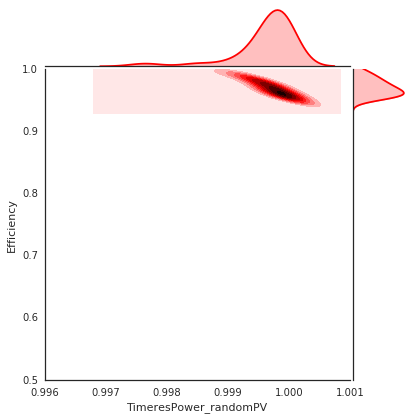

In [20]:
if perform_dilution_scan==False:
    import seaborn as sns; sns.set_style('white')

    x, ys = unpack_cut_dict(cut_to_performance)
    test = pd.DataFrame()
    test['TimeresPower_randomPV'] = np.array(ys['TimeresPower_randomPV'])
    test['Efficiency'] = np.array(ys['Efficiency'])
    y_lim = (0.5,1)
    x_lim = (0.996,1.001)
    g = sns.jointplot(x='TimeresPower_randomPV', y='Efficiency',data=test,stat_func=None,space=0.05, kind="kde",xlim=x_lim,ylim=y_lim, color="r")
    g.savefig("/home/chasenberg/plots/wrong_pv/timres_eff_random_kde.pdf")
    print(test.shape)

In [45]:
test['TimeresPower_randomPV'] = np.array(ys['TimeresPower_randomPV'])
test['TimeresPower_bestPV'] = np.array(ys['TimeresPower_bestPV'])
test['Efficiency'] = np.array(ys['Efficiency'])

In [46]:
test['error']

0     0.973531
1     0.975758
2     0.977487
3     0.979005
4     0.980382
5     0.981595
6     0.982739
7     0.983864
8     0.984916
9     0.985942
10    0.986896
11    0.987832
12    0.988689
13    0.989547
14    0.990342
15    0.991131
16    0.991891
17    0.992646
18    0.993342
19    0.994064
20    0.994753
21    0.995425
22    0.996064
23    0.996671
24    0.997239
25    0.997837
26    0.998385
27    0.998915
28    0.999476
29    1.000000
Name: error, dtype: float64

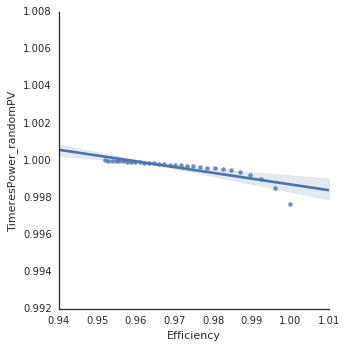

In [53]:
x = test['TimeresPower_randomPV'] = np.array(ys['TimeresPower_randomPV'])
y = test['Efficiency'] = np.array(ys['Efficiency'])
lm = sns.lmplot(x='Efficiency', y='TimeresPower_randomPV',data=test,fit_reg=True)#,x_estimator=np.mean)
axes = lm.axes
#axes[0,0].set_xlim(x.min(),x.max())
#axes[0,0].set_ylim(y.min(),y.max())
lm.savefig("/home/chasenberg/plots/wrong_pv/timres_eff_random.pdf")

### Compare Random PV vs. best PV selection

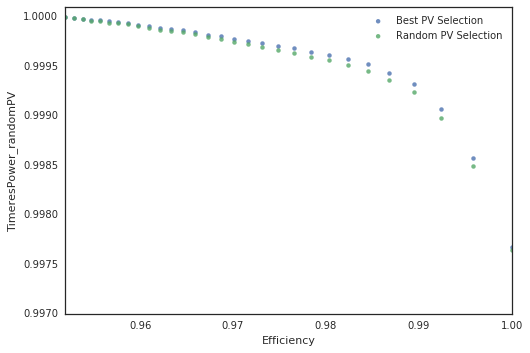

In [55]:
plot_2 = sns.regplot(x='Efficiency', y='TimeresPower_bestPV',data=test, fit_reg=False,label='Best PV Selection')
plot_1 = sns.regplot(x='Efficiency', y='TimeresPower_randomPV',data=test, fit_reg=False,label='Random PV Selection')
plot_1.legend(loc="best")
plot_1.set(xlim=(test['Efficiency'].min(), test['Efficiency'].max()))
plot_1.set(ylim=(0.997,1.0001))
plt.savefig("/home/chasenberg/plots/wrong_pv/timeres_random_vs_bestpv.pdf")

### Write test dataframe to .csv

In [47]:
test.to_csv('/home/chasenberg/plots/csv_data/random.csv')

In [29]:
ys['Efficiency']

array([ 1.        ,  0.99587697,  0.99240589,  0.98945717,  0.98681149,
        0.98456057,  0.98242529,  0.9803558 ,  0.97844182,  0.97655177,
        0.97481723,  0.97315246,  0.97160732,  0.97007016,  0.96866259,
        0.96727097,  0.96593317,  0.9645914 ,  0.96336725,  0.96213114,
        0.96095484,  0.95979648,  0.95869196,  0.9576592 ,  0.95668826,
        0.95566747,  0.95472842,  0.95380333,  0.9528284 ,  0.95193322])

In [30]:
ys['TimeresPower_randomPV']

array([ 0.99764575,  0.99849309,  0.99898065,  0.99923699,  0.99935988,
        0.999457  ,  0.99951065,  0.9995636 ,  0.99959583,  0.99963536,
        0.99966956,  0.99969759,  0.99972332,  0.99974577,  0.99977453,
        0.99979392,  0.99982229,  0.99984252,  0.99985284,  0.99986908,
        0.9998853 ,  0.99990713,  0.99992297,  0.9999351 ,  0.99994121,
        0.99995851,  0.99996083,  0.99997745,  0.99998722,  1.        ])

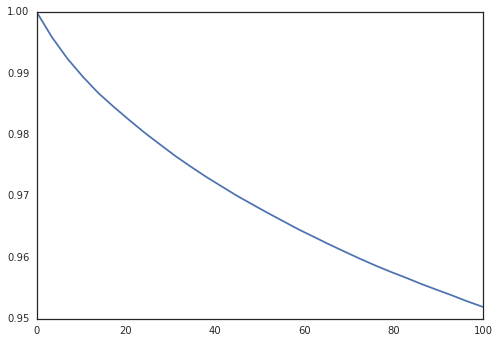

In [31]:
a = test['Efficiency']
plt.plot(cuts,a)
plt.savefig("/home/chasenberg/plots/wrong_pv/eff_random.pdf")

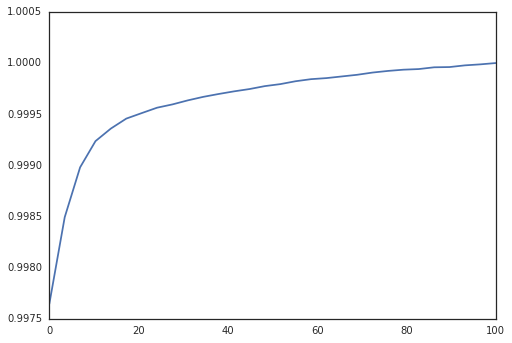

In [32]:
a = test['TimeresPower_randomPV']
plt.plot(cuts,a)
plt.savefig("/home/chasenberg/plots/wrong_pv/timeres_random.pdf")